# A box model of a subglacial plume

Author: Otis Hoffmann

### Libraries

Importing these libraries allows the use of additional functions and better ways to visualize results.

In [1]:
import numpy as np
import cmocean # for special oceanographic colormaps 
import matplotlib.pyplot as plt # for plotting and data visualisation
import gsw # for calculations with the TEOS-10

### Constants

Defining empirical constants and coefficients here makes them easier to use later on.

In [2]:
y1 = -5.73e-2 # Empirical parameters for the freezing temperature equation 
y2 = 8.32e-2  
y3 = 7.61e-4
c_i = 2009 # Specific heat capacity ice
c_p = 3974 # Specific heat capacity ocean water
L = 3.34e5 # Latent heat of fusion
St_T = 1.1e-3 # Stranton number temperature
St_S = 3.1e-5 # Stranton number salinity
E_0 = 3.6e-2 # Entrainment coefficient

### Boundary Conditions

The boundary conditions for the plume layer underneath the floating ice tongue of 79NG. Can be adapted to fit the plume layer of other glaciers.

In [3]:
T_i = - 20 # Temperature glacier ice
h = 10 # Plume height
l = 80000 # Plume length
w = 20000 # Plume width
z_g = -600 # Grounding line depth
z_b = -300 # Average depth of the plume
u = 0.2 # Plume velocity
A = w * l # Plume area between plume and ice or plume and ambient water
V = A * h # Plume Volume
sin_alpha = np.sin(np.arctan(np.abs(z_g) / l)) # Sine of the plume's slope
gamma_T = St_T * u # Temperature exchange velocity
gamma_S = St_S * u # Salinity exchange velocity

### Potential temperature and in situ temperature compared

A function for the freezing temperature is defined.

In [4]:
def freeze(S, z_b):
    T = y1 * S + y2 + y3 * z_b
    return T

The graphic created by this section attempts to show that the differentiation between the two temperatures is not necessary.

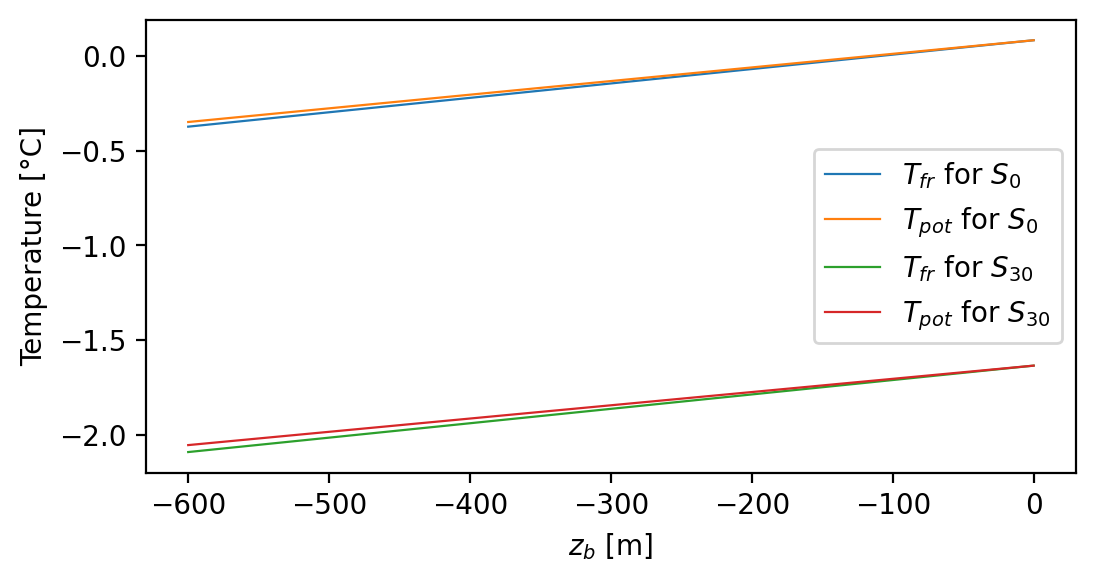

In [5]:
S = 30
z_bot = -600
z_top = 0
z_b = np.linspace(z_bot, z_top, 100)
p = gsw.p_from_z(z_b, 79)

fig = plt.figure(figsize=(6,3), dpi= 200, facecolor='w', edgecolor='k')
plt.plot(z_b, freeze(0,z_b), linewidth=0.8, label= '$T_{fr}$ for $S_0$')
plt.plot(z_b, gsw.pt0_from_t(0, y1 * 0 + y2 + y3 * z_b, p), linewidth=0.8, label= '$T_{pot}$ for $S_0$')
plt.plot(z_b, freeze(S,z_b), linewidth=0.8, label= '$T_{fr}$ for $S_{30}$')
plt.plot(z_b, gsw.pt0_from_t(0, y1 * S + y2 + y3 * z_b, p), linewidth=0.8, label= '$T_{pot}$ for $S_{30}$')

plt.xlabel('$z_b$ [m]')
plt.ylabel('Temperature [°C]')
plt.legend()
plt.show()

### Basal Melting

As first part of the model, a function 'basalmelting' to calculate the glaciers melt rate from plume temperature and salinity can be defined. To investigate, whether or not, the average depth of the plume has an impact on the melt rate, it is included as input parameter for the function.

In [6]:
s_yr = 3600 * 24 * 365 # From seconds to years

In [7]:
def basalmelting(S, T, z_b):
    a = y1 * (gamma_T - gamma_S * c_i/c_p)
    b = gamma_T * (y2 + y3 * z_b - T) + gamma_S/c_p * (c_i * (y1* S - y2 - y3 * z_b + T_i) - L)
    c = (gamma_S * S) / c_p * (c_i * (y3 * z_b - T_i) + L)
    S_b = - (b + np.sqrt(b ** 2 - 4 * a * c)) / (2 * a)
    T_b = y1 * S_b + y2 + y3 * z_b
    v_b = (gamma_S * (S - S_b)) / S_b
    return {
        "S_b": S_b,
        "T_b": T_b,
        "v_b": v_b * s_yr, # Melt rate in m/y
    }

In [8]:
basalmelting(30, -1.5, -300)["v_b"]

16.966925668608255

Below, an examplary visualization for how the melt rate function works is demonstrated. In this case for a salinity of $S$ =30 g/kg and $T$ in a range from freezing temperature to 0°C.

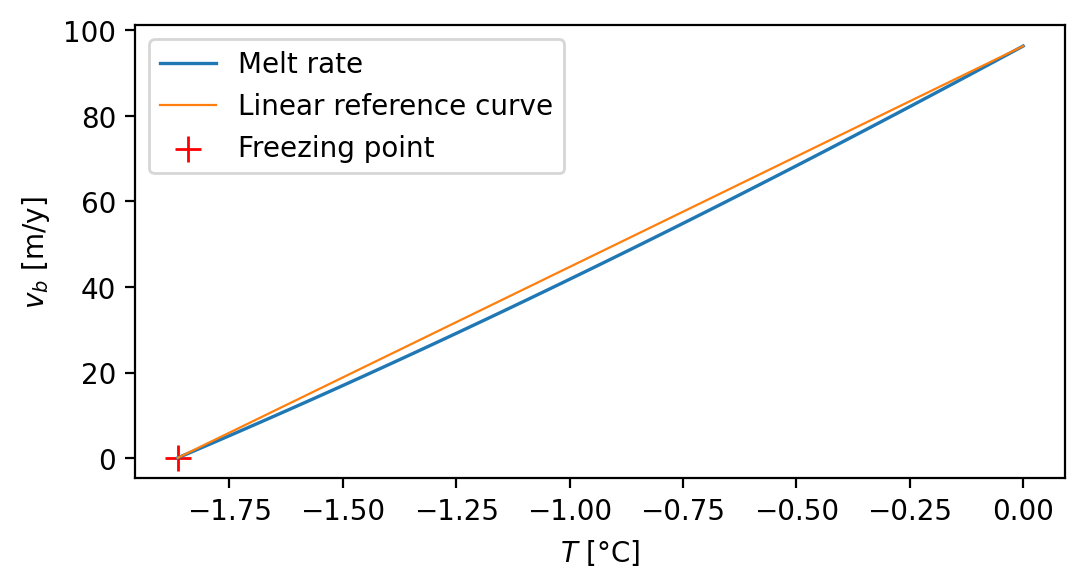

In [9]:
S = 30
T_max = 0
z_b = -300
T_fr = freeze(S,z_b)
T = np.linspace(T_fr, T_max, 100)
fig = plt.figure(figsize=(6,3), dpi= 200, facecolor='w', edgecolor='k')
plt.plot(T, basalmelting(S, T, z_b)["v_b"], linewidth=1.2, label= 'Melt rate')
plt.xlabel('$T$ [°C]')
plt.ylabel('$v_b$ [m/y]')
x = [T_fr, T_max]
y = [basalmelting(S, T_fr, z_b)["v_b"], basalmelting(S, T_max, z_b)["v_b"]]
plt.plot(x, y, linewidth = 0.8, label = 'Linear reference curve')
plt.scatter(T_fr, basalmelting(S, T_fr, z_b)["v_b"], marker='+', c='red', s=90, linewidth=1, label= 'Freezing point')
plt.legend()
plt.show()

Same graphic but for different depths of the plume layer.

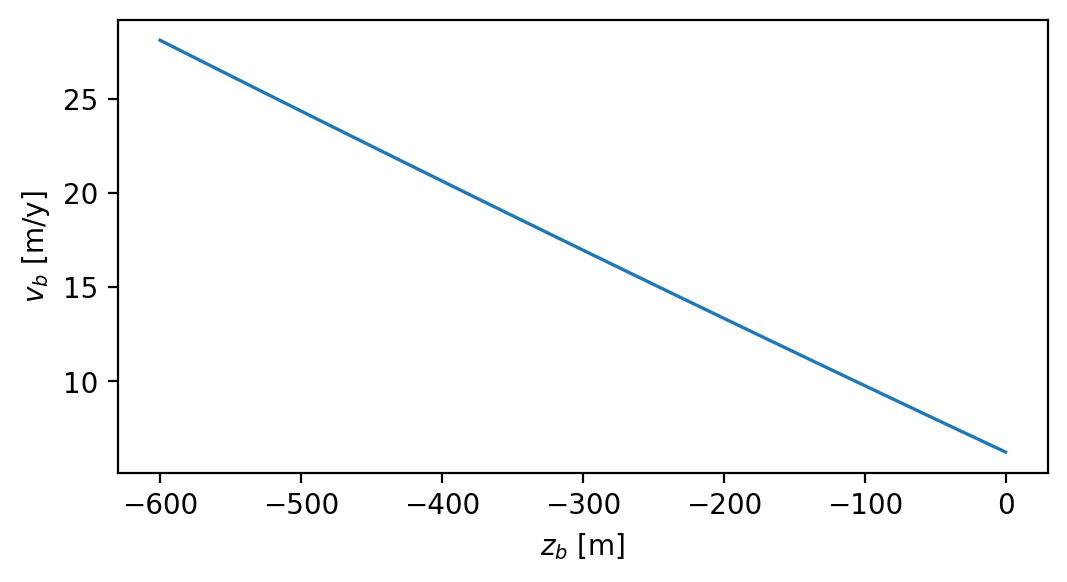

In [10]:
S = 30
T = -1.5
z_bot = -600
z_top = 0
z_b = np.linspace(z_bot, z_top, 100)

fig = plt.figure(figsize=(6,3), dpi= 200, facecolor='w', edgecolor='k')
plt.plot(z_b, basalmelting(S, T, z_b)["v_b"], linewidth=1.2, label= 'Melt rate')
plt.xlabel('$z_b$ [m]')
plt.ylabel('$v_b$ [m/y]')
plt.show()

## The box model

For the loop of iterations, the parameters for subglacial discharge and entrainment are calculated.

In [11]:
S_g = 0 # The water discharged is freshwater from the glacier ice
T_g =freeze(S_g, z_g) # Potential discharge temperature

v_e = E_0 * u * sin_alpha # Entrainment velocity
Q_a = v_e * A # Entrainment transport

Timestep $\Delta t$ and number of iterations $N$ determine the accuracy and computation time of the model.

In [12]:
dt = 10000
N = 200

The function 'boxmodel' can now be defined and used to calculate the meltrate of the glacier as well as other values that might be of interest in a for loop. Input variables will be the salinity and potential temperatures of the ambient water as well as the transport from subglacial discharge.

In [13]:
def boxmodel(S_a, T_a, Q_g, z_b):

    # empty arrays for values of interest
    v_b_n = np.full(N, np.nan)
    S_n = np.full(N, np.nan)
    T_n = np.full(N, np.nan)
    Q_m_n = np.full(N, np.nan)
    Q_out_n = np.full(N, np.nan)
    S_b_n = np.full(N, np.nan)
    T_b_n = np.full(N, np.nan)
    
    S = 30 # starting value for the plume
    T = freeze(S, z_b)
    
    for i in range(N):
        # basal melting
        bmelt = basalmelting(S, T, z_b)
        S_b = bmelt["S_b"]
        T_b = bmelt["T_b"]
        v_b = (gamma_S * (S - S_b)) / S_b # Calling the 'basalmelting' function instead does not seem to work
        Q_m = v_b * A
        
        # plume parameters
        Q = - (Q_g + Q_m + Q_a)
        S = (Q_a * S_a + V/dt * S) / (V/dt - Q)
        T = (Q_a * T_a + Q_g * T_g + (Q_m + A * gamma_T) * T_b + V/dt * T) / (V/dt - Q + A * gamma_T)
        
        # filling of the arrays to be returned by the function
        v_b_n[i] = v_b
        S_n[i] = S
        T_n[i] = T
        S_b_n[i] = S_b
        T_b_n[i] = T_b
        Q_m_n[i] = Q_m
        Q_out_n[i] = Q
        
    return {
        "v_b": v_b_n * s_yr,
        "S": S_n,
        "T": T_n,
        "S_b": S_b_n,
        "T_b": T_b_n,
        "Q_m": Q_m_n,
        "Q_out": Q_out_n,
    }

### The model applied

The values determined by the function can be saved in a dictionary to be visualized or used later on.

In [14]:
S_a = 33
T_a = -1
Q_g = 70
z_b = -300
result = boxmodel(S_a, T_a, Q_g, z_b)


Some other scenarios can be calculated and compared

In [15]:
future = boxmodel(35, 0, 70, -300)
adaptedQ_g = boxmodel(35, 0, 144.8, -300)

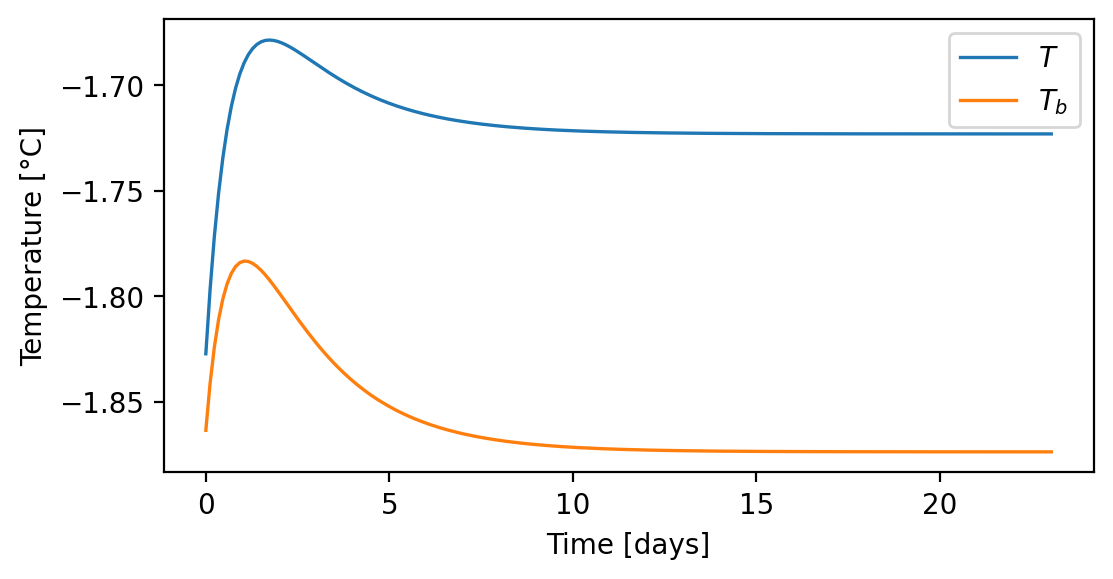

In [16]:
time = np.arange(0, N, 1) * dt / 60 / 60 / 24 # time in days

fig = plt.figure(figsize=(6,3), dpi= 200, facecolor='w', edgecolor='k')
plt.plot(time, result['T'], linewidth=1.2, label = '$T$')
plt.plot(time, future['T_b'], linewidth=1.2, label = '$T_b$')
plt.xlabel('Time [days]')
plt.ylabel('Temperature [°C]')
plt.legend()
plt.show()

Of special interest here are the melt rate in meters per year, as well as the ratio between transport from melting and transport from subglacial discharge. Both are shown below, with the time axis in days to get a better idea of the time scales. Added aswell are two other scenarios to show different outcomes for different environmental parameters.

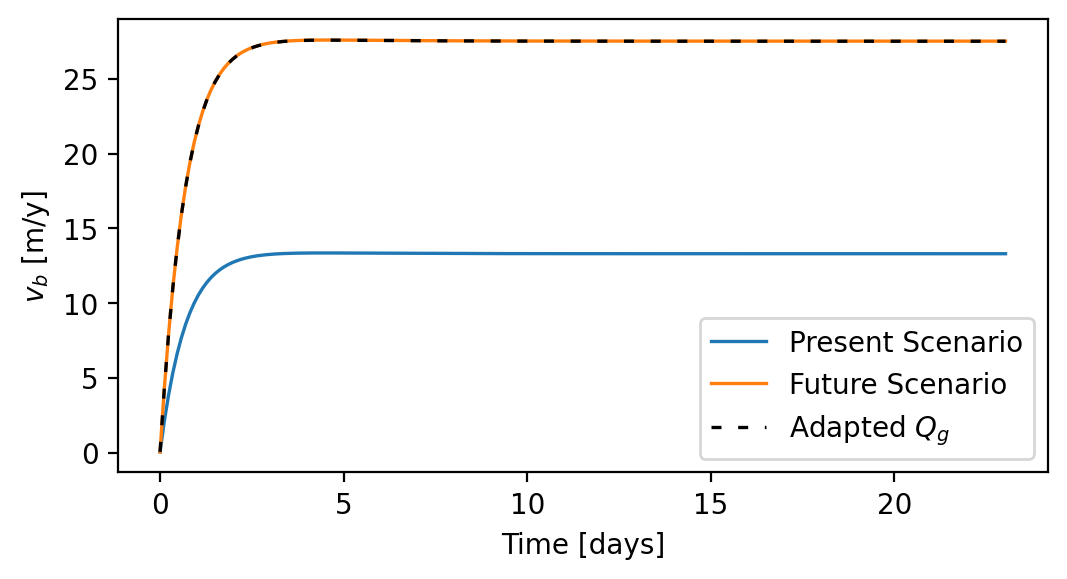

In [17]:
time = np.arange(0, N, 1) * dt / 60 / 60 / 24 # time in days

fig = plt.figure(figsize=(6,3), dpi= 200, facecolor='w', edgecolor='k')
plt.plot(time, result['v_b'], linewidth=1.2, label = 'Present Scenario')
plt.plot(time, future['v_b'], linewidth=1.2, label = 'Future Scenario')
plt.plot(time, adaptedQ_g['v_b'], linewidth=1.2, label = 'Adapted $Q_g$', c = "k", linestyle =  (0, (3, 5)))
plt.xlabel('Time [days]')
plt.ylabel('$v_b$ [m/y]')
plt.legend()
plt.show()

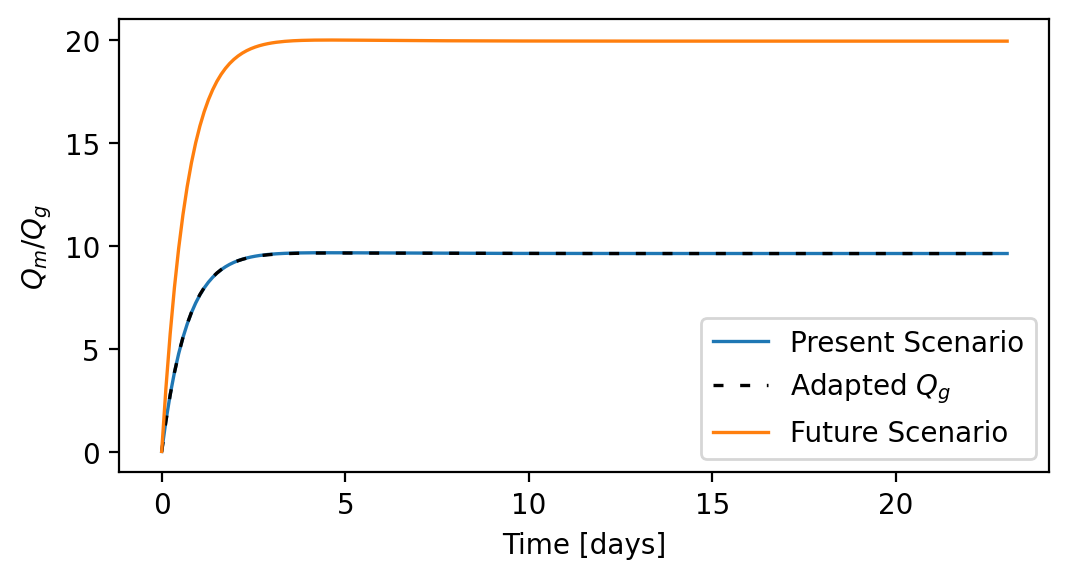

In [18]:
fig = plt.figure(figsize=(6,3), dpi= 200, facecolor='w', edgecolor='k')
plt.plot(time, result['Q_m'] / Q_g, linewidth=1.2, label = 'Present Scenario')
plt.plot(time, adaptedQ_g['Q_m'] / 144.8, linewidth=1.2, label = 'Adapted $Q_g$', c = "k", linestyle =  (0, (3, 5)))
plt.plot(time, future['Q_m'] / Q_g, linewidth=1.2, label = 'Future Scenario')
plt.xlabel('Time [days]')
plt.ylabel('$Q_m/Q_g$')
plt.legend()
plt.show()

## Sensitivity Study

Out of the environmental parameters $T_a$, $S_a$, $Q_g$ and the average depth of the plume layer $z_b$, one is varied while the others remain constant to see how the model reacts to the change. The constant parameters are the ones used in the present scenario.

In [19]:
T_a = -1
S_a = 33
Q_g = 70
z_b = -300

For this case, the development of values during the loop are not relevant. The new function "sens_study" works just like "boxmodel" but only returns the last calculated value. This allows for arrays as input parameters.

In [20]:
def sens_study(S_a, T_a, Q_g, z_b): 
    S = 30 # starting value for the plume
    T = freeze(S, z_b)
    
    for i in range(N):
        # basal melting
        bmelt = basalmelting(S, T, z_b)
        S_b = bmelt["S_b"]
        T_b = bmelt["T_b"]
        v_b = (gamma_S * (S - S_b)) / S_b # Calling the 'basalmelting' function instead does not seem to work
        Q_m = v_b * A
        
        # plume parameters
        Q = - (Q_g + Q_m + Q_a)
        S = (Q_a * S_a + V/dt * S) / (V/dt - Q)
        T = (Q_a * T_a + Q_g * T_g + (Q_m + A * gamma_T) * T_b + V/dt * T) / (V/dt - Q + A * gamma_T)
        
    return {
        "v_b": v_b * s_yr,
        "S": S,
        "T": T,
        "S_b": S_b,
        "T_b": T_b,
        "Q_m": Q_m,
        "Q_out": Q,
    }

### Varying the ambient water temperature $T_a$

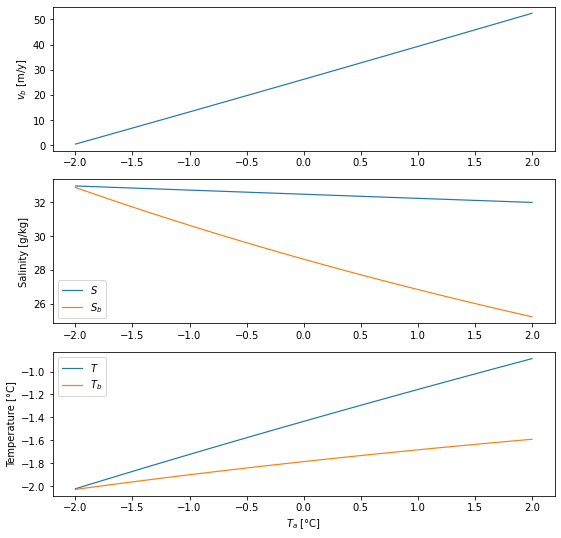

In [21]:
S_a = 33
Q_g = 70
z_b = -300
T_bot = -2
T_top = 2
T_a = np.linspace(T_bot, T_top, 100)
    
fig, axs = plt.subplots(3, figsize=(9,9))
axs[0].plot(T_a, sens_study(S_a, T_a, Q_g, z_b)["v_b"], linewidth=1.2)
axs[0].set_ylabel('$v_b$ [m/y]')
axs[1].plot(T_a, sens_study(S_a, T_a, Q_g, z_b)["S"], linewidth=1.2, label= '$S$')
axs[1].plot(T_a, sens_study(S_a, T_a, Q_g, z_b)["S_b"], linewidth=1.2, label= '$S_b$')
axs[1].set_ylabel('Salinity [g/kg]')
axs[1].legend()
axs[2].plot(T_a, sens_study(S_a, T_a, Q_g, z_b)["T"], linewidth=1.2, label= '$T$')
axs[2].plot(T_a, sens_study(S_a, T_a, Q_g, z_b)["T_b"], linewidth=1.2, label= '$T_b$')
axs[2].set_xlabel('$T_a$ [°C]')
axs[2].set_ylabel('Temperature [°C]')
axs[2].legend()
plt.show()

### Varying the ambient water salinity $S_a$

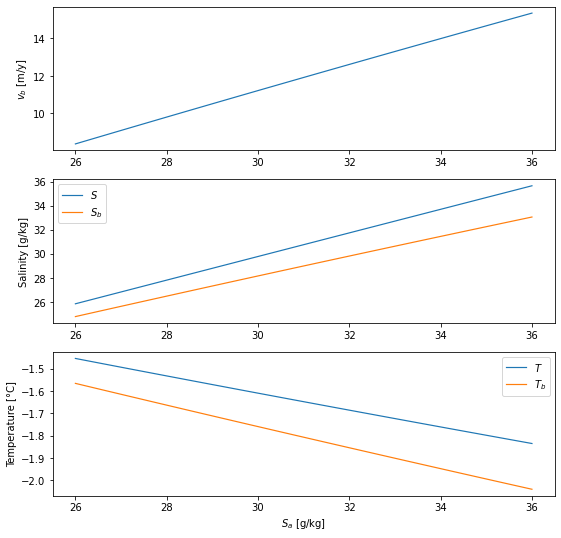

In [22]:
T_a = -1
Q_g = 70
z_b = -300
S_bot = 26
S_top = 36
S_a = np.linspace(S_bot, S_top, 100)
    
fig, axs = plt.subplots(3, figsize=(9,9))
axs[0].plot(S_a, sens_study(S_a, T_a, Q_g, z_b)["v_b"], linewidth=1.2)
axs[0].set_ylabel('$v_b$ [m/y]')
axs[1].plot(S_a, sens_study(S_a, T_a, Q_g, z_b)["S"], linewidth=1.2, label= '$S$')
axs[1].plot(S_a, sens_study(S_a, T_a, Q_g, z_b)["S_b"], linewidth=1.2, label= '$S_b$')
axs[1].set_ylabel('Salinity [g/kg]')
axs[1].legend()
axs[2].plot(S_a, sens_study(S_a, T_a, Q_g, z_b)["T"], linewidth=1.2, label= '$T$')
axs[2].plot(S_a, sens_study(S_a, T_a, Q_g, z_b)["T_b"], linewidth=1.2, label= '$T_b$')
axs[2].set_xlabel('$S_a$ [g/kg]')
axs[2].set_ylabel('Temperature [°C]')
axs[2].legend()
plt.show()

### Varying the transport from subglacial discharge $Q_g$

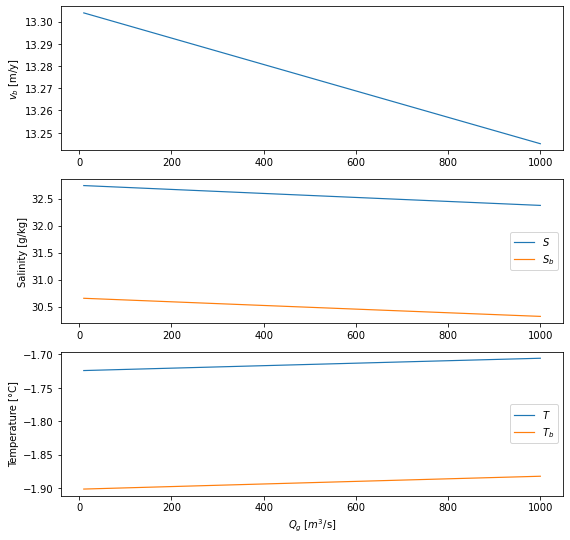

In [23]:
T_a = -1
S_a = 33
z_b = -300
Q_bot = 10
Q_top = 1000
Q_g = np.linspace(Q_bot, Q_top, 100)
    
fig, axs = plt.subplots(3, figsize=(9,9))
axs[0].plot(Q_g, sens_study(S_a, T_a, Q_g, z_b)["v_b"], linewidth=1.2)
axs[0].set_ylabel('$v_b$ [m/y]')
axs[1].plot(Q_g, sens_study(S_a, T_a, Q_g, z_b)["S"], linewidth=1.2, label= '$S$')
axs[1].plot(Q_g, sens_study(S_a, T_a, Q_g, z_b)["S_b"], linewidth=1.2, label= '$S_b$')
axs[1].set_ylabel('Salinity [g/kg]')
axs[1].legend()
axs[2].plot(Q_g, sens_study(S_a, T_a, Q_g, z_b)["T"], linewidth=1.2, label= '$T$')
axs[2].plot(Q_g, sens_study(S_a, T_a, Q_g, z_b)["T_b"], linewidth=1.2, label= '$T_b$')
axs[2].set_xlabel('$Q_g$ [$m^3$/s]')
axs[2].set_ylabel('Temperature [°C]')
axs[2].legend()
plt.show()

### Varying the average depth of the plume layer $z_b$

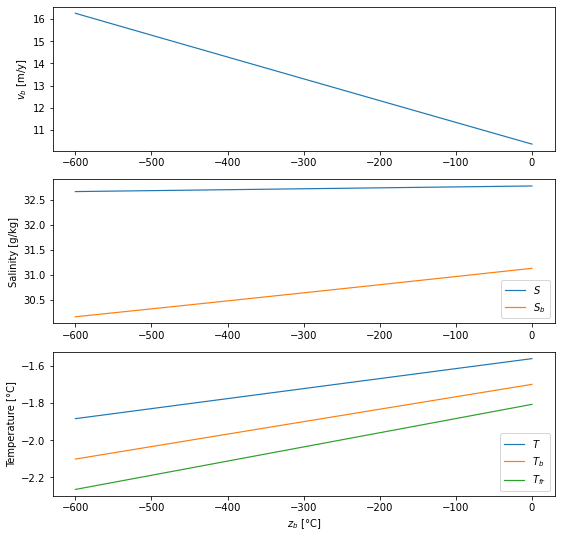

In [24]:
T_a = -1
S_a = 33
Q_g = 70
z_bot = -600
z_top = 0
z_b = np.linspace(z_bot, z_top, 100)
    
fig, axs = plt.subplots(3, figsize=(9,9))
axs[0].plot(z_b, sens_study(S_a, T_a, Q_g, z_b)["v_b"], linewidth=1.2)
axs[0].set_ylabel('$v_b$ [m/y]')
axs[1].plot(z_b, sens_study(S_a, T_a, Q_g, z_b)["S"], linewidth=1.2, label= '$S$')
axs[1].plot(z_b, sens_study(S_a, T_a, Q_g, z_b)["S_b"], linewidth=1.2, label= '$S_b$')
axs[1].set_ylabel('Salinity [g/kg]')
axs[1].legend()
axs[2].plot(z_b, sens_study(S_a, T_a, Q_g, z_b)["T"], linewidth=1.2, label= '$T$')
axs[2].plot(z_b, sens_study(S_a, T_a, Q_g, z_b)["T_b"], linewidth=1.2, label= '$T_b$')
axs[2].plot(z_b, y1*S_a+y2+y3*z_b, linewidth=1.2, label= '$T_{fr}$') # adding the freezing temperature
axs[2].set_xlabel('$z_b$ [°C]')
axs[2].set_ylabel('Temperature [°C]')
axs[2].legend()
plt.show()

## Varying multiple parameters

It is very unlikely that only one of the parameters will change so color maps are used to simulate a more realistic scenario where two parameters change. The most interesting ones are the temperature and salinity of the ambient water, the patter below can be adapted to any other combination however. To create the color maps, the function 'variation' is defined. X is the resolution of the colormap.

In [25]:
def variation(S_bot, S_top, T_bot, T_top, Q_g, z_b, Quantity, X):
    colormap = np.zeros((X,X))
    for i in range(0, X):
        for k in range(0, X):
            salt = S_bot + i * (S_top - S_bot) / X
            temp = T_bot + k * (T_top - T_bot) / X
            if temp >= y1 * salt + y2 + y3 * z_b:
                colormap[i,k] = sens_study(salt, temp, Q_g, z_b)[Quantity]
            else:
                colormap[i,k] = np.nan
    return colormap.transpose()

In [26]:
S_bot = 30
S_top = 35
T_bot = -2
T_top = 2
Q_g = 70
z_b = -300
X = 200

Salinity = np.arange(S_bot, S_top + (S_top-S_bot) / X, (S_top-S_bot) / (X-1))
Freeze = y1 * Salinity + y2 + y3* z_b
Temperature = np.arange(T_bot, T_top + (T_top-T_bot) / X, (T_top-T_bot) / (X-1))

The results can then be plotted using the 'cmocean' package

#### Melt rate $v_b$

In [27]:
v_b_Ta_Sa = variation(S_bot, S_top, T_bot, T_top, Q_g, z_b, "v_b", X)

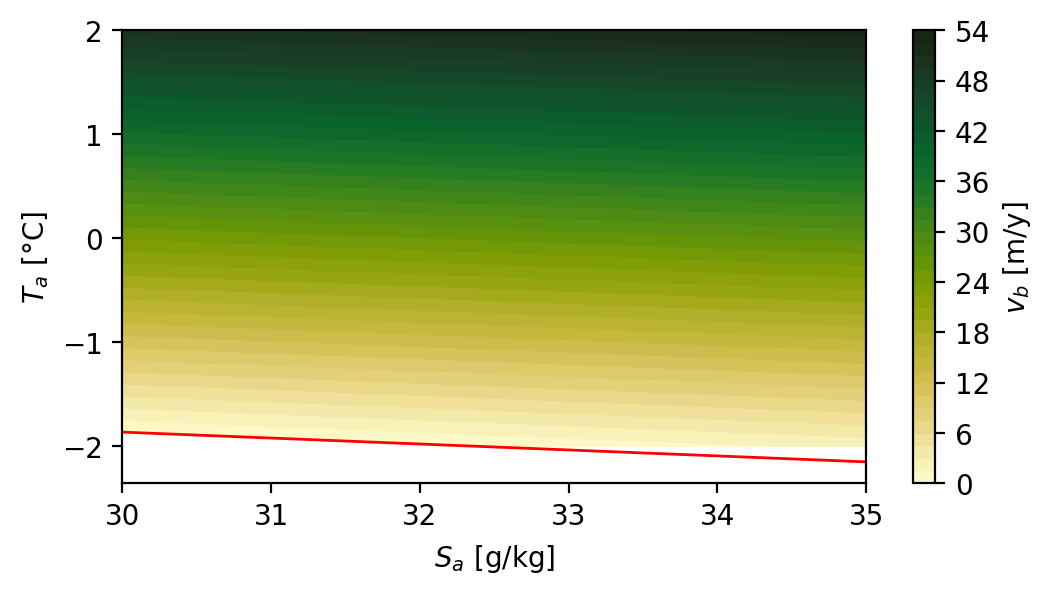

In [28]:
fig = plt.figure(figsize=(6,3), dpi= 200, facecolor='w', edgecolor='k')
im = plt.contourf(Salinity, Temperature, v_b_Ta_Sa,levels=40,cmap=cmocean.cm.speed)
plt.colorbar(label = '$v_b$ [m/y]')
plt.plot(Salinity, Freeze, color= 'red', linewidth = 1)
plt.xlabel('$S_a$ [g/kg]')
plt.ylabel('$T_a$ [°C]')
plt.show()

#### Plume temperature $T$

In [29]:
T_Ta_Sa = variation(S_bot, S_top, T_bot, T_top, Q_g, z_b, "T", X)

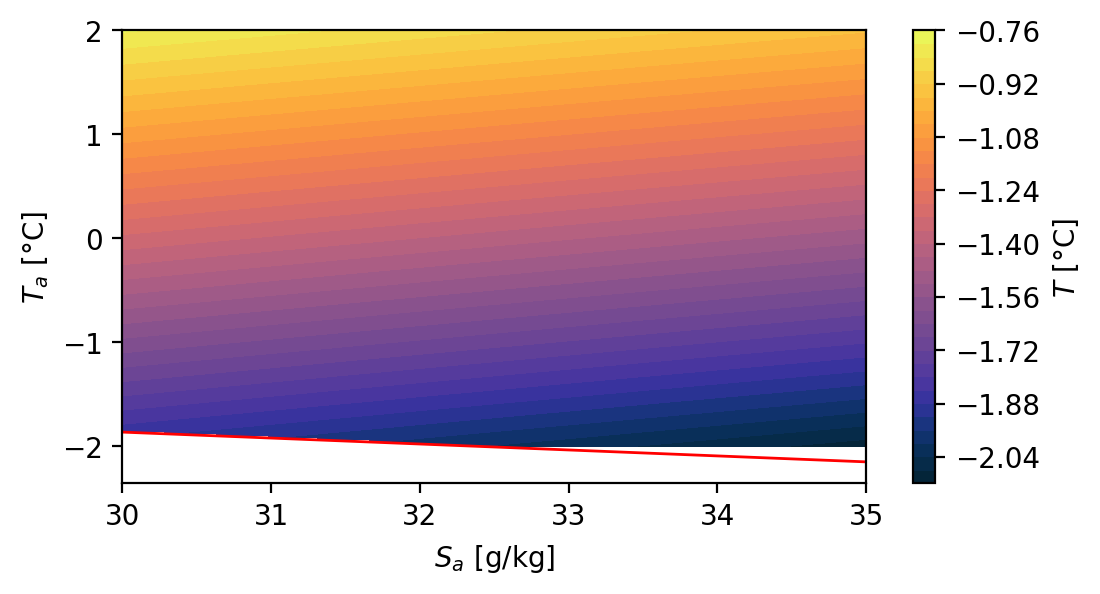

In [30]:
fig = plt.figure(figsize=(6,3), dpi= 200, facecolor='w', edgecolor='k')
im = plt.contourf(Salinity, Temperature, T_Ta_Sa,levels=40,cmap=cmocean.cm.thermal)
plt.colorbar(label = '$T$ [°C]')
plt.plot(Salinity, Freeze, color= 'red', linewidth = 1)
plt.xlabel('$S_a$ [g/kg]')
plt.ylabel('$T_a$ [°C]')
plt.show()

#### Melt layer temperature $T_b$

In [31]:
Tb_Ta_Sa = variation(S_bot, S_top, T_bot, T_top, Q_g, z_b, "T_b", X)

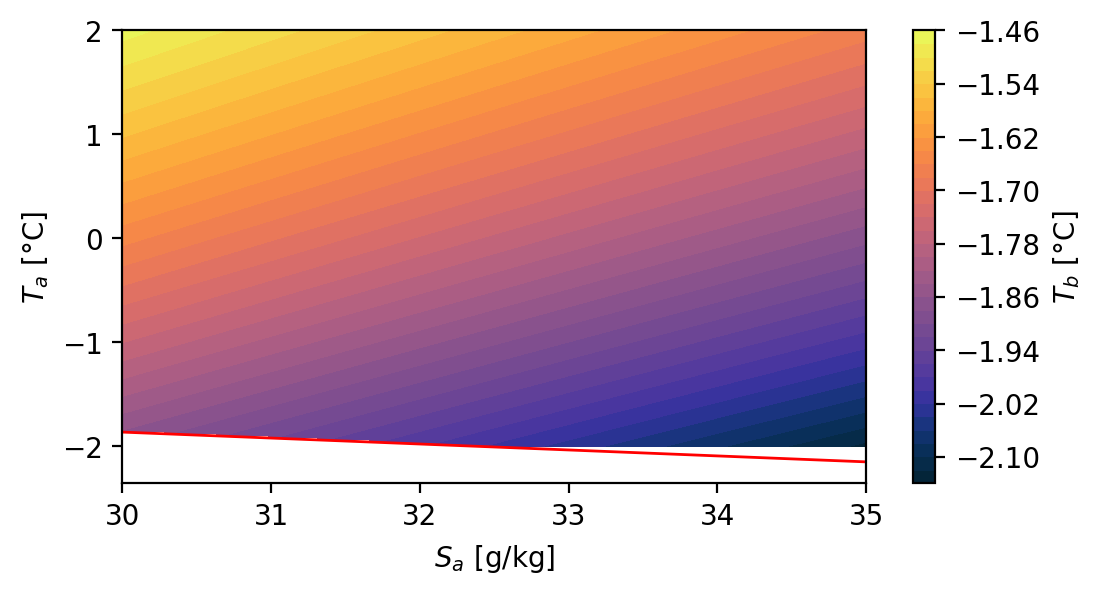

In [32]:
fig = plt.figure(figsize=(6,3), dpi= 200, facecolor='w', edgecolor='k')
im = plt.contourf(Salinity, Temperature, Tb_Ta_Sa,levels=40,cmap=cmocean.cm.thermal)
plt.colorbar(label = '$T_b$ [°C]')
plt.plot(Salinity, Freeze, color= 'red', linewidth = 1)
plt.xlabel('$S_a$ [g/kg]')
plt.ylabel('$T_a$ [°C]')
plt.show()

#### Plume salinity $S$

In [33]:
S_Ta_Sa = variation(S_bot, S_top, T_bot, T_top, Q_g, z_b, "S", X)

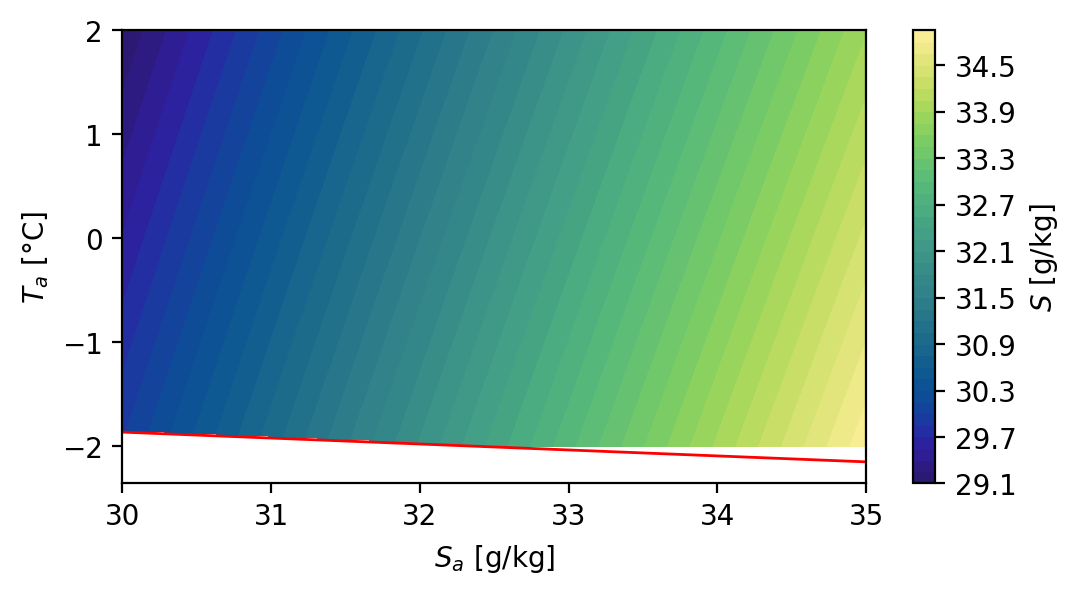

In [34]:
fig = plt.figure(figsize=(6,3), dpi= 200, facecolor='w', edgecolor='k')
im = plt.contourf(Salinity, Temperature, S_Ta_Sa,levels=40,cmap=cmocean.cm.haline)
plt.colorbar(label = '$S$ [g/kg]')
plt.plot(Salinity, Freeze, color= 'red', linewidth = 1)
plt.xlabel('$S_a$ [g/kg]')
plt.ylabel('$T_a$ [°C]')
plt.show()

#### Salinity melt layer $S_b$

In [35]:
Sb_Ta_Sa = variation(S_bot, S_top, T_bot, T_top, Q_g, z_b, "S_b", X)

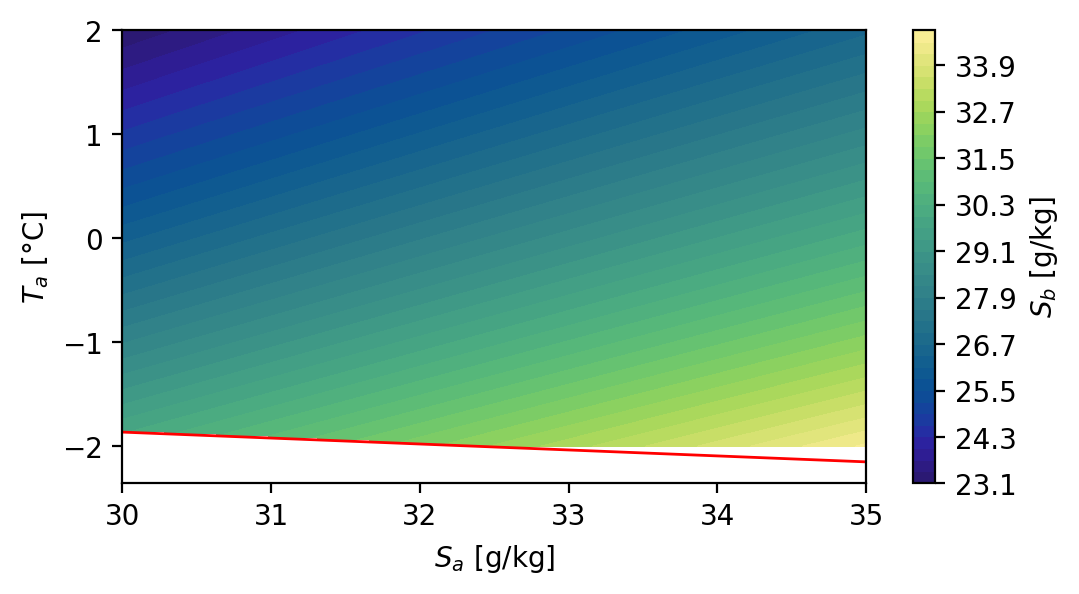

In [36]:
fig = plt.figure(figsize=(6,3), dpi= 200, facecolor='w', edgecolor='k')
im = plt.contourf(Salinity, Temperature, Sb_Ta_Sa,levels=40,cmap=cmocean.cm.haline)
plt.colorbar(label = '$S_b$ [g/kg]')
plt.plot(Salinity, Freeze, color= 'red', linewidth = 1)
plt.xlabel('$S_a$ [g/kg]')
plt.ylabel('$T_a$ [°C]')
plt.show()

#### Melt rate for changing $Q_g$

In [37]:
DeltaMR_Q = variation(S_bot, S_top, T_bot, T_top, Q_g, z_b, "v_b", X) - variation(S_bot, S_top, T_bot, T_top, 1000, z_b, "v_b", X)

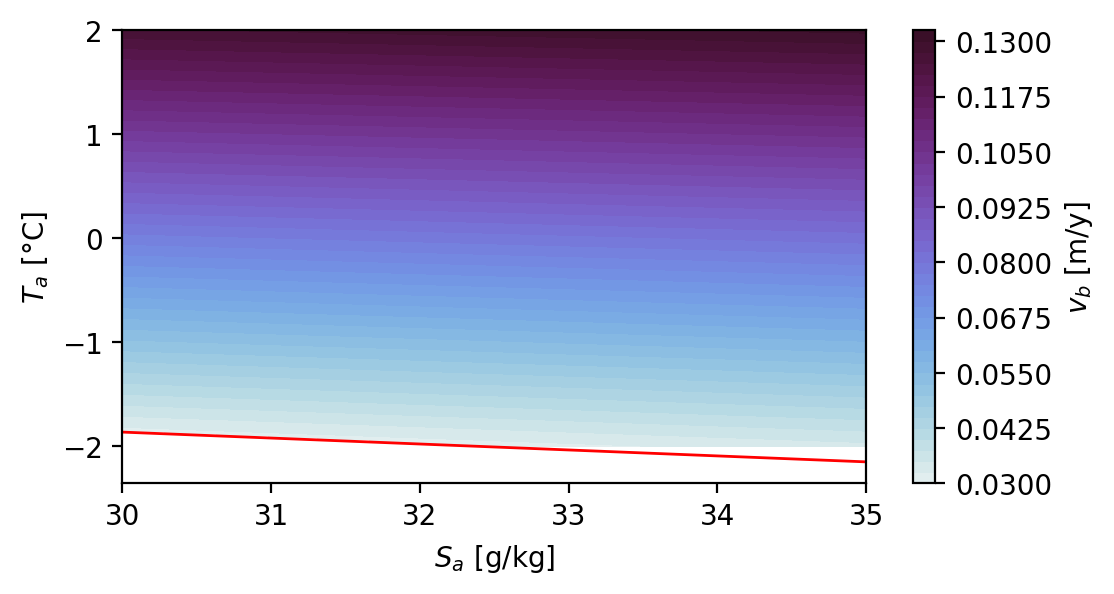

In [38]:
fig = plt.figure(figsize=(6,3), dpi= 200, facecolor='w', edgecolor='k')
im = plt.contourf(Salinity, Temperature, DeltaMR_Q, levels = 40, cmap=cmocean.cm.dense)
plt.colorbar(label = '$v_b$ [m/y]')
plt.plot(Salinity, Freeze, color= 'red', linewidth = 1)
plt.xlabel('$S_a$ [g/kg]')
plt.ylabel('$T_a$ [°C]')
plt.show()

#### Melt rate for changing $z_b$

In [39]:
DeltaMR_z = variation(S_bot, S_top, T_bot, T_top, Q_g, z_b, "v_b", X) - variation(S_bot, S_top, T_bot, T_top, Q_g, -50, "v_b", X)

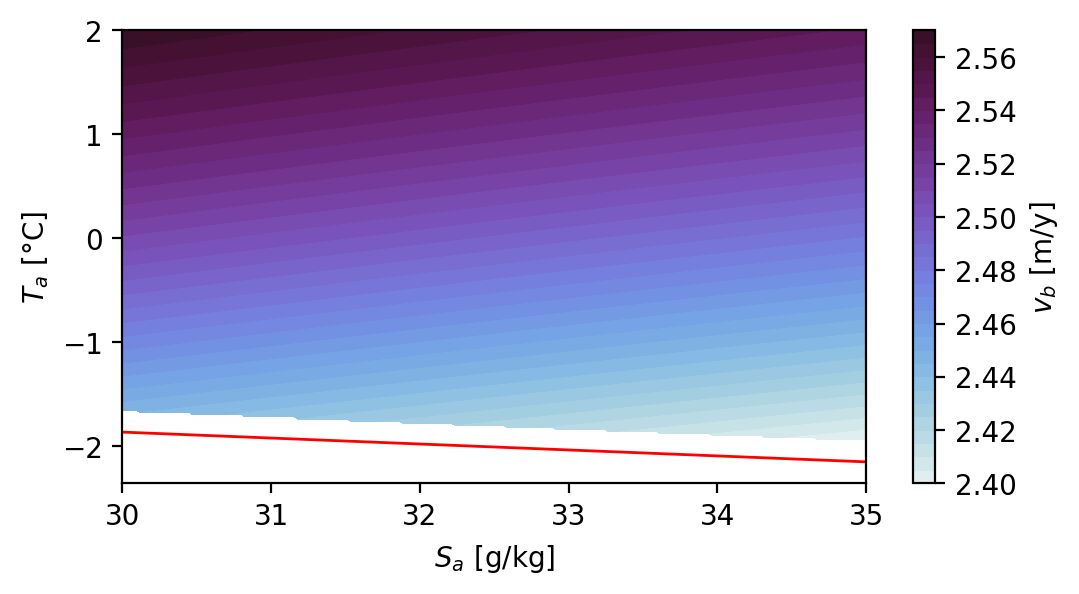

In [40]:
fig = plt.figure(figsize=(6,3), dpi= 200, facecolor='w', edgecolor='k')
im = plt.contourf(Salinity, Temperature, DeltaMR_z, levels = 40, cmap=cmocean.cm.dense)
plt.colorbar(label = '$v_b$ [m/y]')
plt.plot(Salinity, Freeze, color= 'red', linewidth = 1)
plt.xlabel('$S_a$ [g/kg]')
plt.ylabel('$T_a$ [°C]')
plt.show()